In [6]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from IPython.display import Image

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [7]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '../Resources/dataset' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ../Resources/dataset\notMNIST_large.tar.gz
Found and verified ../Resources/dataset\notMNIST_small.tar.gz


In [8]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

../Resources/dataset\notMNIST_large already present - Skipping extraction of ../Resources/dataset\notMNIST_large.tar.gz.
['../Resources/dataset\\notMNIST_large\\A', '../Resources/dataset\\notMNIST_large\\B', '../Resources/dataset\\notMNIST_large\\C', '../Resources/dataset\\notMNIST_large\\D', '../Resources/dataset\\notMNIST_large\\E', '../Resources/dataset\\notMNIST_large\\F', '../Resources/dataset\\notMNIST_large\\G', '../Resources/dataset\\notMNIST_large\\H', '../Resources/dataset\\notMNIST_large\\I', '../Resources/dataset\\notMNIST_large\\J']
../Resources/dataset\notMNIST_small already present - Skipping extraction of ../Resources/dataset\notMNIST_small.tar.gz.
['../Resources/dataset\\notMNIST_small\\A', '../Resources/dataset\\notMNIST_small\\B', '../Resources/dataset\\notMNIST_small\\C', '../Resources/dataset\\notMNIST_small\\D', '../Resources/dataset\\notMNIST_small\\E', '../Resources/dataset\\notMNIST_small\\F', '../Resources/dataset\\notMNIST_small\\G', '../Resources/dataset\\no

In [9]:
displayFile = os.path.join(train_folders[0], 'a2F6b28udHRm.png')
Image(filename=displayFile)

In [10]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)

  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))

  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

../Resources/dataset\notMNIST_large\A.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_large\B.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_large\C.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_large\D.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_large\E.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_large\F.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_large\G.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_large\H.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_large\I.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_large\J.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_small\A.pickle already present - Skipping pickling.
../Resources/dataset\notMNIST_small\B.pickle already present - Skipping pickling.
../Resources/dat

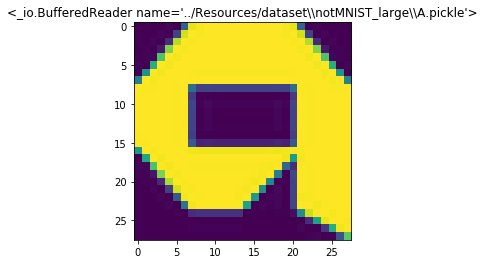

In [19]:
def show_data(data):
  with (open(data, "rb")) as openfile:
    try:
        letter_set = pickle.load(openfile)
        plt.imshow(letter_set[0])
        plt.title(openfile)
    except EOFError:
        print("Something wrong")

show_data(train_datasets[0])

In [12]:
def get_letter_by_index(index):
  setOfLetter = 'abcdefghij'
  return setOfLetter[index]

def check_balance():
  number_of_set = len(train_datasets)
  
  for i in range(0, number_of_set):
    with (open(train_datasets[i], "rb")) as openfile:
      try:
          letter_set = pickle.load(openfile)
          print('Dataset for class', get_letter_by_index(i), 'size:', len(letter_set))
      except EOFError:
          print("Something wrong")
          
check_balance()

Dataset for class a size: 52909
Dataset for class b size: 52911
Dataset for class c size: 52912
Dataset for class d size: 52911
Dataset for class e size: 52912
Dataset for class f size: 52912
Dataset for class g size: 52912
Dataset for class h size: 52912
Dataset for class i size: 52912
Dataset for class j size: 52911


In [13]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [16]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)

test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Text(0.5,1,'4')

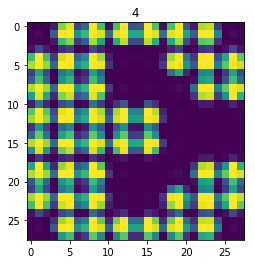

In [21]:
plt.imshow(train_dataset[0])
plt.title(train_labels[0])